# Neural & Behavioral Modeling - Week 12 (Exercises)
by Ting-Yu, Lin (tylin.amice@gmail.com)

In [ ]:
# Upgrade PyTorch to 0.4.0 if necessary:
! conda install -y pytorch-cpu torchvision-cpu -c pytorch

In [5]:
%config IPCompleter.greedy=True 
%matplotlib inline
from matplotlib.pyplot import *
from IPython.display import *
import numpy as np

In [6]:
# Check GPU status:
import torch as t
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 0.4.0
Device  0 : Tesla K80
Device  1 : Tesla K80
Current: Device  0


In [3]:
! nvidia-smi

Fri May 18 09:47:49 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 387.26                 Driver Version: 387.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   44C    P0    56W / 149W |   2875MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   32C    P8    31W / 149W |     37MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

## 1 Fair Performance Assessment (5 points)
We often compare and assess performances of different model architectures/parameters/hyperparameters. Note that the results are differnt even if you re-run exactly the same code block. This is primarily due to a non-fixed random number seed. Please:

(1) run the section 1.2 TEN times and report (a) min, (b) max, (c) mean, & (d) standard deviation of the TESTING accuracies. (3 points)

(2) try to fix the random number seeds in numpy & pytorch to see if you can obtain the same results every time in the section 1.2. (2 points)

### 1.0 CIFAR-10 dataset

In [7]:
# Load the dataset:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

train_set = CIFAR10(root='.', train=True, transform=transforms.ToTensor(), download=True)
train_data = t.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
test_set = CIFAR10(root='.', train=False, transform=transforms.ToTensor())
test_data = t.utils.data.DataLoader(train_set, batch_size=1000, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


### 1.1 The model

In [8]:
# Make the model:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # = nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 6, 5) # in, out, kernel
        self.conv2 = nn.Conv2d(6, 16, 5) 
        self.fc1   = nn.Linear(16*5*5, 120) 
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
    def forward(self, x): # functional expressions
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
lenet = Net()
lenet = lenet.to(device)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(lenet.parameters())

### 1.2 Training & Testing

In [9]:
#test N times (N=10)
Ntest = 10
testAccArr = np.empty(Ntest)
for j in range(Ntest):
    # Training:
    for e in range(2):
        for i, (X_train, Y_train) in enumerate(train_data, 0):
            X_train,Y_train=X_train.to(device),Y_train.to(device)
            Y_pred = lenet(X_train)
            loss = loss_fn(Y_pred, Y_train)
            lenet.zero_grad()
            loss.backward()
            optimizer.step()   
            Y_pred = lenet(X_train)
            Y_pred = t.max(Y_pred,1)[1]
        print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
        
    # Testing on a batch:
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)
    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1]
        print('test :',(Y_pred==Y_test).sum().item()/Y_test.shape[0])
        testAccArr[j] = (Y_pred==Y_test).sum().item()/Y_test.shape[0]
print(testAccArr)

epoch  0 : 0.3125
epoch  1 : 0.3125
test : 0.509
epoch  0 : 0.375
epoch  1 : 0.375
test : 0.562
epoch  0 : 0.375
epoch  1 : 0.375
test : 0.608
epoch  0 : 0.375
epoch  1 : 0.5625
test : 0.629
epoch  0 : 0.4375
epoch  1 : 0.5625
test : 0.64
epoch  0 : 0.5625
epoch  1 : 0.75
test : 0.663
epoch  0 : 0.75
epoch  1 : 0.75
test : 0.686
epoch  0 : 0.75
epoch  1 : 0.8125
test : 0.693
epoch  0 : 0.8125
epoch  1 : 0.75
test : 0.702
epoch  0 : 0.8125
epoch  1 : 0.75
test : 0.701
[0.509 0.562 0.608 0.629 0.64  0.663 0.686 0.693 0.702 0.701]


#### HW11 1.1 results

In [10]:
testmin = np.min(testAccArr)
testmax = np.max(testAccArr)
testmean = np.mean(testAccArr)
testsd = np.std(testAccArr)
print("min: ",testmin,"max: ",testmax, "mean: ",testmean, "sd:", testsd)

min:  0.509 max:  0.702 mean:  0.6393 sd: 0.06115889142226172


In [16]:
#set random seed
#np.random.seed(1)
#t.manual_seed(1)
#t.cuda.manual_seed_all(1)
#test random seed
#np.random.rand()
#t.randn(1)

Ntest = 10
testAccArr = np.empty(Ntest)


for j in range(Ntest):
    # Training:
    #np.random.seed(j)
    #t.manual_seed(j)
    print(j)
    for e in range(2):
        #np.random.seed(j+e*100)
        #t.manual_seed(j+e*100)
        #print(j)
        for i, (X_train, Y_train) in enumerate(train_data, 0):
            X_train,Y_train=X_train.to(device),Y_train.to(device)
            Y_pred = lenet(X_train)
            loss = loss_fn(Y_pred, Y_train)
            lenet.zero_grad()
            loss.backward()
            optimizer.step()   
            Y_pred = lenet(X_train)
            Y_pred = t.max(Y_pred,1)[1]
        print('epoch ',e,':',(Y_pred==Y_train).sum().item()/Y_train.shape[0])
        
    # Testing on a batch:
    dataiter = iter(test_data)
    X_test, Y_test = dataiter.next() # returning a batch
    X_test,Y_test=X_test.to(device),Y_test.to(device)
    with t.no_grad():
        Y_pred = lenet(X_test)
        Y_pred = t.max(Y_pred,1)[1]
        print('test :',(Y_pred==Y_test).sum().item()/Y_test.shape[0])
        testAccArr[j] = (Y_pred==Y_test).sum().item()/Y_test.shape[0]
#np.random.seed(1)
#t.manual_seed(1)

print(testAccArr)

0
epoch  0 : 0.9375
epoch  1 : 0.9375
test : 0.756
1
epoch  0 : 0.9375
epoch  1 : 1.0
test : 0.727
2
epoch  0 : 0.9375
epoch  1 : 1.0
test : 0.735
3
epoch  0 : 1.0
epoch  1 : 1.0
test : 0.765
4
epoch  0 : 1.0
epoch  1 : 1.0
test : 0.754
5
epoch  0 : 1.0
epoch  1 : 1.0
test : 0.75
6
epoch  0 : 0.9375
epoch  1 : 1.0
test : 0.721
7
epoch  0 : 0.9375
epoch  1 : 0.875
test : 0.749
8
epoch  0 : 0.9375
epoch  1 : 1.0
test : 0.753
9
epoch  0 : 1.0
epoch  1 : 1.0
test : 0.75
[0.756 0.727 0.735 0.765 0.754 0.75  0.721 0.749 0.753 0.75 ]


### 1.3 Your answers

試過了用numpy, pytorch(GPU版,非GPU版都試過)設random seed，也用最簡單的random測試過random seed的code沒有問題，也有試著在不同的地方，如：一開頭、不同迴圈的頭設random seed，但依舊無法重製。

## 2 Universal Approximation Theorem (5 points)

Please FAIRLY assess whether a deep network learns XOR more efficiently than a shallow network with the same number of model parameters. Please discuss why in either case.

### 2.0 XOR data

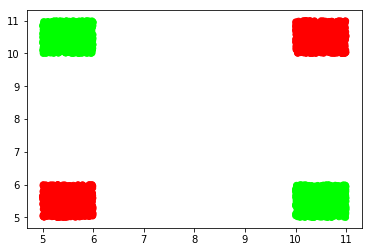

In [66]:
N=1000 # samples per cluster
XY=t.tensor([[5,5],[5,10],[10,5],[10,10]],dtype=t.float32) # 4 cluster centers
Z=t.tensor([0,1,1,0]) # category labels
t.cat([t.randn(2,1)+XY[0,0],t.randn(2,1)+XY[0,1]],1)
xy,z=t.zeros(4*N,2),t.zeros(4*N,dtype=t.int64)
for i in range(4):
    xy[i*N:(i+1)*N,]=t.rand(N,2)+XY[i,]
    z[i*N:(i+1)*N]=Z[i]
xy_np=xy.numpy()
z_np=z.numpy().astype(int)
cmap=np.array([[1,0,0],[0,1,0]])
scatter(xy_np[:,0],xy_np[:,1],color=cmap[z_np]);

#### 2.1 A shallow net with one hidden layer

In [137]:
# Number of free parameters: 2*H+H*2=70

# H=35 # number of hidden units
H= 35
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
#     t.nn.Sigmoid()
#     t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

epoch  0 : 0.26
epoch  1 : 0.274
epoch  2 : 0.289
epoch  3 : 0.3135
epoch  4 : 0.33575
epoch  5 : 0.36325
epoch  6 : 0.40475
epoch  7 : 0.48325
epoch  8 : 0.5
epoch  9 : 0.5
epoch  10 : 0.5
epoch  11 : 0.5
epoch  12 : 0.5015
epoch  13 : 0.50875
epoch  14 : 0.5305
epoch  15 : 0.5705
epoch  16 : 0.71475
epoch  17 : 0.74025
epoch  18 : 0.75
epoch  19 : 0.75
epoch  20 : 0.75
epoch  21 : 0.75
epoch  22 : 0.75
epoch  23 : 0.75
epoch  24 : 0.75
epoch  25 : 0.75
epoch  26 : 0.75
epoch  27 : 0.75
epoch  28 : 0.75
epoch  29 : 0.75
epoch  30 : 0.75
epoch  31 : 0.75
epoch  32 : 0.75
epoch  33 : 0.75
epoch  34 : 0.751
epoch  35 : 0.8045
epoch  36 : 0.89775
epoch  37 : 0.922
epoch  38 : 0.9455
epoch  39 : 0.9575
epoch  40 : 0.96425
epoch  41 : 0.9725
epoch  42 : 0.9775
epoch  43 : 0.98225
epoch  44 : 0.9865
epoch  45 : 0.9905
epoch  46 : 0.99425
epoch  47 : 0.99625
epoch  48 : 0.998
epoch  49 : 0.99925
epoch  50 : 1.0
epoch  51 : 1.0
epoch  52 : 1.0
epoch  53 : 1.0
epoch  54 : 1.0
epoch  55 : 1.0
ep

#### 2.2 A "deep" net with three hidden layers

In [132]:
# Number of free parameters: 2*H+H*H+H*H+H*2=70

H=5 # number of hidden units
model = t.nn.Sequential(
    t.nn.Linear(2, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H,bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, H, bias=False),
    t.nn.BatchNorm1d(H),
    t.nn.ReLU(),
    t.nn.Linear(H, 2, bias=False),
    t.nn.Softmax(dim=1)
)
loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters())

for i in range(100):
    z_pred = model(xy)
    loss = loss_fn(z_pred,z)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    z_pred = model(xy) 
    z_pred = t.max(z_pred,1)[1]
    print('epoch ',i,':',(z_pred==z).sum().item()/xy.shape[0])

epoch  0 : 0.75
epoch  1 : 0.75
epoch  2 : 0.75
epoch  3 : 0.75
epoch  4 : 0.75
epoch  5 : 0.75
epoch  6 : 0.75
epoch  7 : 0.75
epoch  8 : 0.75
epoch  9 : 0.75
epoch  10 : 0.75
epoch  11 : 0.75
epoch  12 : 0.75
epoch  13 : 0.75
epoch  14 : 0.75
epoch  15 : 0.75
epoch  16 : 0.75
epoch  17 : 0.75
epoch  18 : 0.75
epoch  19 : 0.75
epoch  20 : 0.75
epoch  21 : 0.75
epoch  22 : 0.75
epoch  23 : 0.75
epoch  24 : 0.75
epoch  25 : 0.75
epoch  26 : 0.75
epoch  27 : 0.75
epoch  28 : 0.75
epoch  29 : 0.75
epoch  30 : 0.75
epoch  31 : 0.75
epoch  32 : 0.75
epoch  33 : 0.75
epoch  34 : 0.75
epoch  35 : 0.75
epoch  36 : 0.75
epoch  37 : 0.75
epoch  38 : 0.75
epoch  39 : 0.75
epoch  40 : 0.75
epoch  41 : 0.75
epoch  42 : 0.75
epoch  43 : 0.75
epoch  44 : 0.75
epoch  45 : 0.75
epoch  46 : 0.75
epoch  47 : 0.75
epoch  48 : 0.75
epoch  49 : 0.75
epoch  50 : 0.75
epoch  51 : 0.75
epoch  52 : 0.75
epoch  53 : 0.75
epoch  54 : 0.75
epoch  55 : 0.75
epoch  56 : 0.75
epoch  57 : 0.75
epoch  58 : 0.75
epoch  

### 2.3 Your answers

在這個case中，看起來"deep"的表現不一定會比"shallow"來得好。(達到ACC = 1之epoch數沒有比較小, 甚至有時候會出現沒有收斂的狀態(一直達不到ACC = 1))

原因可能是XOR算是一個簡單的問題，所以deep net能夠學習子類別、減小search space的優勢就沒有出來。